# Import dependancies

In [1]:
import os, re
import pandas as pd
from summarise.io import doc_to_csv
from summarise.io import pdf_to_text_file
from summarise.preprocess import cleaner, tokeniser, remove_whitespace, clean_text, clean_tokens, find_references
from summarise.visualise import plot_wordcloud, plot_histogram, count_document_tokens, count_tokens, highlight_entities, count_entities
from summarise.model import TextRank4Keyword
import numpy as np
import spacy
#nlp = spacy.load("en_core_web_lg") #includes word vectors

# Fetch raw data

In [2]:
# Define constants
ROOT        = os.path.abspath('') #current directory
DATA_FOLDER = os.path.join( ROOT, 'data')
ALL_DATA    = os.path.join( DATA_FOLDER, 'all_data.csv' )
if os.path.isfile( ALL_DATA ):
    # Read pre-processed data
    df          = pd.read_csv( ALL_DATA )
else:
    # Create from scratch
    filenames   = pdf_to_text_file( DATA_FOLDER )
    df          = doc_to_csv( filenames, ALL_DATA )
df.head()

,Unnamed: 0,Name,Text
0,0,cyborg-supervision-speech-by-james-proudman.txt,\r\n\r\n \r\n \r\n \r\n \r\n \r\n \r\n \r\n \...
1,1,managing-machines-the-governance-of-artificial...,\r\n\r\n \r\n \r\n \r\n \r\n \r\n \r\n \r\n \...
2,2,supervisor-centred-automation-the-role-of-huma...,\r\n\r\n \r\n \r\n \r\n \r\n \r\n \r\n \r\n \...


# Pre-processing

In [3]:
documents   = df['Text'].values.tolist()
token_list  = [tokeniser( clean_text(doc), allowed_postags=['NOUN','PROPN', 'VERB'] ) for doc in documents]

# Exploratory Analysis

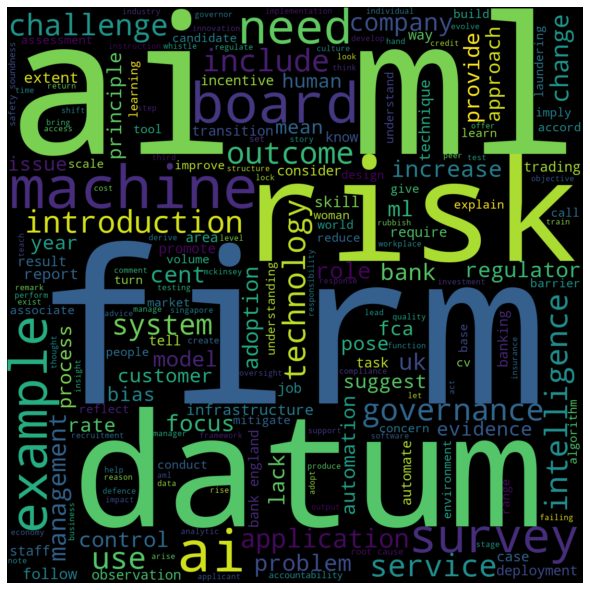

In [4]:
# Word cloud
plt = plot_wordcloud(token_list[1])

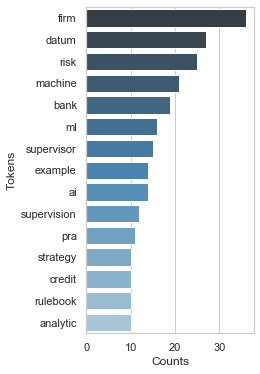

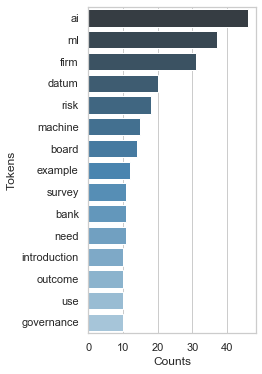

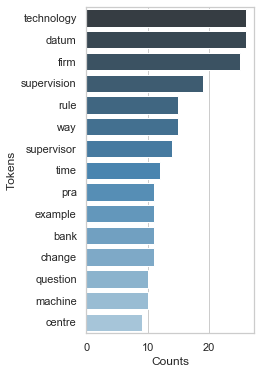

In [5]:
# Word frequency
plts = [plot_histogram(tokens) for tokens in token_list]


In [6]:
# Document frequency
token_counts_df = count_document_tokens(token_list)
token_counts_df.columns=['Document 1','Document 2','Document 3']
token_counts_df.head(25)

,Document 1,Document 2,Document 3
firm,36.0,31.0,25.0
datum,27.0,20.0,26.0
risk,25.0,18.0,8.0
machine,21.0,15.0,10.0
bank,19.0,11.0,11.0
ml,16.0,37.0,NaN
supervisor,15.0,1.0,14.0
example,14.0,12.0,11.0
ai,14.0,46.0,3.0
supervision,12.0,1.0,19.0


In [7]:
# Entity Analysis
highlight_entities( remove_whitespace( documents[2], False ), 20 )

In [27]:
# Extract references
refs = find_references(documents[2])
for r in refs:
    print(r)


26 March 2020 

1 Or whatever device we are using by then. 

2 “Cyborg supervision – the application of advanced analytics in prudential supervision” 19 November 2018 

3 “New economy, new finance, new Bank”, speech by Mark Carney, 21 June 2018 

4 Bank of England Discussion Paper, 7 January 2020 

5 “Credit union meets robot”, speech by Sam Woods, 24 October 2019 


In [9]:
entities_df = count_entities( clean_text(documents[0]) )
entities_df.head(20)


,Counts
Tokens,
PRA,8
AI,7
Bank of England,3
Financial Stability Board,2
Ryan Lovelock,1
New Frontier,1
New Physics of Financial Services,1
PageRank,1
Pete Thomas,1


# Modelling

In [10]:
# Import sklearn classes
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
# Import spacy
import spacy

In [11]:
# Feature engineering - bag of words
bow_vector      = CountVectorizer( 
                        tokenizer = tokeniser,
                        token_pattern='[a-zA-Z0-9]{3,}', # num chars > 3                       
                        ngram_range=(1,1), #only consider unigrams
                        max_features=500,
                        max_df=0.75 #exclude tokens that occur in >75% of the corpus
                        )

In [12]:
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
# Number of topics
number_topics = 3
# Create LDA model
lda = LDA( 
        n_components = number_topics, 
        n_jobs=-1, 
        random_state=42
        )
# Create pipeline using Bag of Words
pipe = Pipeline([('cleaner', cleaner()),
                 ('vectoriser', bow_vector),
                 ('reduce_dim', lda)])
# Data
X = df['Text'].values.tolist()

In [13]:
# Optimise hyperparameters
from sklearn.model_selection import GridSearchCV
# Define Search Param
search_params = {'reduce_dim__learning_decay': [.5, .7, .9], 'reduce_dim__doc_topic_prior': [.01, .1, .3], 'reduce_dim__topic_word_prior': [.01, .1, .3]}
# Initialise the Model
search = GridSearchCV( pipe, param_grid = search_params, cv=3, n_jobs=-1 )

In [14]:
# Do the Grid Search
#search.fit(X)
# Return best parameter set
#search.best_params_

In [15]:
#results = pd.DataFrame(search.cv_results_)
#results.head()

In [16]:
# Create LDA model with optimal parameters
lda = LDA( 
        n_components = number_topics, 
        n_jobs=-1, 
        random_state=42,
        learning_decay=0.5,
        doc_topic_prior=0.01,
        topic_word_prior=0.3
        )
# Create pipeline using Bag of Words
pipe = Pipeline([('cleaner', cleaner()),
                 ('vectoriser', bow_vector),
                 ('reduce_dim', lda)])

In [17]:
# Fit model
pipe.fit(X)
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
# Print the topics found by the LDA model
number_words = 10 
print("Topics found via LDA:")
print_topics(pipe[2], pipe[1], number_words)

Topics found via LDA:

Topic #0:
survey governance use company cent control adoption infrastructure suggest bias

Topic #1:
supervisory use supervision letter rulebook part supervise research tool analyse

Topic #2:
supervision question centre advance objective code real regulated able know


# Summarisation

In [18]:
nlp     = spacy.load("en_core_web_lg")    
text    = clean_text( X[0] )
doc     = nlp( text )

In [19]:
# Create mean sentence vectors
sentences = list( doc.sents )
sentence_vectors = []
ROWS = sentences[0].vector.size
for sentence in sentences:
    clean = filter(clean_tokens, sentence)
    clean_sentence = list(clean)
    n_tokens = len(clean_sentence)
    if n_tokens !=0:
        v = sum([t.vector for t in clean_sentence]) / n_tokens
    else:
        v = np.zeros((ROWS,))
    sentence_vectors.append(v)
# Subtract mean vector
#sentence_vectors = sentence_vectors - (sum(sentence_vectors) / len(sentences))

In [20]:
# Create similarity matrix
from sklearn.metrics.pairwise import cosine_similarity
n_sentences = len(sentences)
similarity_matrix = np.zeros([n_sentences, n_sentences])
for i in range(n_sentences):
    for j in range(n_sentences):
        if i != j:
            similarity_matrix[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,ROWS), sentence_vectors[j].reshape(1,ROWS))[0,0]

In [21]:
import networkx as nx
nx_graph    = nx.from_numpy_array(similarity_matrix)
scores      = nx.pagerank(nx_graph, max_iter=100)

In [22]:
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)

In [23]:
# Extract top 10 sentences as the summary
for i in range(10):
  print(ranked_sentences[i][1])

So – along the same lines pursued by law firms for example – one big win is the ability to produce structured data from a range of sources, the analysis of which traditionally required significant manual effort.
The research has the practical application for focusing our scarce supervisory resources in a systematic and efficient way on those credit unions where they are most likely to be needed.
This would allow regulators to collect data on an ad hoc basis from firms as required, in close to real time without any manual intervention at either end.
To achieve complex supervisory outcomes – which often require significant, multi-year remediation by firms – boards and senior management of firms have to understand the context and rationale for what we are trying to achieve, as well as what we would deem to be a successful outcome.
Described as a business process, it can be broken down into a number of simple steps: 1) rule-setting and reporting; 2) analysis and monitoring; and 3) setting 

In [24]:
text    = clean_text( X[0] )
tr4w    = TextRank4Keyword()
tr4w.analyze(text, candidate_pos = ['NOUN', 'PROPN'], window_size=4, lower=False)
tr4w.get_keywords(15)

data - 9.88828442218169
firms - 9.869341349776148
example - 5.32578839201495
AI - 5.174715652836902
risks - 4.675113712853181
supervision - 4.5346088590123586
machine - 4.038761361214538
credit - 3.960675362588351
ML - 3.9496477278739346
supervisors - 3.8514666917624227
PRA - 3.8364358087105193
analytics - 3.573311505075187
time - 3.375986678939539
banks - 3.068895444628691
J. - 3.034722916666666
information - 2.9071718567355793
machines - 2.9027820513804667


In [25]:
text    = clean_text( X[1] )
tr4w    = TextRank4Keyword()
tr4w.analyze(text, candidate_pos = ['NOUN', 'PROPN'], window_size=4, lower=False)
tr4w.get_keywords(15)

AI - 10.609017171132596
ML - 7.845398440538232
data - 6.9649085335997905
firms - 6.600124435003335
technology - 4.497154838054021
example - 3.864643586937306
governance - 3.715915180870417
intelligence - 3.61902148445234
boards - 3.4015006204351717
outcomes - 3.339830976558639
risk - 3.0692849190223326
risks - 3.0641678822638827
management - 3.0015507370674777
UK - 2.8676761690981976
infrastructure - 2.756341167078646
machines - 2.737722818396616
introduction - 2.6737646683263945
